In [1]:
import pandas as pd
import numpy as np
import spacy
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

In [37]:
from torchvision import datasets

In [41]:
data = datasets.MNIST("data", download=True)

In [14]:
class Model(nn.Module):
    def __init__(self, seq_len, h_in):
        super(Model, self).__init__()
        
        self.num_layers = 1
        self.seq_len = seq_len
        self.h_in    = h_in
        
        self.lstm = nn.LSTM(input_size = self.seq_len, 
                            hidden_size = self.h_in, 
                            num_layers = self.num_layers
                           )
        
        self.fc1 = nn.Linear(h_in, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        
        self.relu = nn.ReLU()
        
        self.fc = nn.Linear(16, 1)
        
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.h_in)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.h_in)
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.h_in)
        out = self.relu(hn)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc(out)
        
        return out

In [ ]:
class ModelBuilder:
    def __init__(self, model, optimizer, criterion, seq_len):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.seq_len = seq_len
        self.embed_dim = 300
        
    def get_features(self, texts):
        nlp_texts = [nlp(text) for text in texts]
        feats = np.zeros((len(nlp_texts), self.seq_len, self.embed_dim))

        for i in range(len(nlp_texts)):
            text = nlp_texts[i]
            feats[i][0:min(len(text), self.seq_len)] = [word.vector for word in text[0:min(len(text), self.seq_len)]]
            
        return feats
    
    def get_data_loaders(self, feats, labels, batch_size = 8, test_size=0.1):
        X_train, X_test, y_train, y_test = train_test_split(feats, feats, test_size=test_size)
        
        dataloader_train = DataLoader(X_train, )
        
        
    def train(self, X_train, y_train):
        

In [2]:
wd = './'
train_path = wd + 'train.csv'
random_state = 1

In [3]:
np.random.seed(random_state)

In [4]:
data = pd.read_csv(train_path)

In [5]:
data.sort_values('target').reset_index()

,index,id,url_legal,license,excerpt,target,standard_error
0,1705,4626100d8,NaN,NaN,"The commutator is peculiar, consisting of only...",-3.676268,0.623621
1,1128,493b80aa7,NaN,NaN,The Dunwich horror itself came between Lammas ...,-3.668360,0.571404
2,1754,fe44cbd14,NaN,NaN,"The iron cylinder weighs 23 kilogrammes; but, ...",-3.642892,0.644398
3,1752,284eaa5ad,NaN,NaN,As to surface-slope its measurement—from nearl...,-3.639936,0.603819
4,1720,9e9eacb49,NaN,NaN,"The tree is dioecious, bearing male catkins on...",-3.636834,0.606822
...,...,...,...,...,...,...,...
2829,1066,016913371,https://www.africanstorybook.org/,CC BY 4.0,Grandma's garden was wonderful. It was full of...,1.467665,0.599600
2830,1014,7a1d484be,https://www.africanstorybook.org/,CC BY 4.0,More people came to the bus stop just before 9...,1.541672,0.606997
2831,808,8f35441e3,https://www.africanstorybook.org/#,CC BY 4.0,"Every day, Emeka's father took him to school i...",1.583847,0.624776
2832,981,849971671,https://www.africanstorybook.org/,CC BY 4.0,"For her last birthday, Sisanda had a special t...",1.597870,0.596349


In [6]:
data['target'].describe()

count    2834.000000
mean       -0.959319
std         1.033579
min        -3.676268
25%        -1.690320
50%        -0.912190
75%        -0.202540
max         1.711390
Name: target, dtype: float64

In [7]:
data['standard_error']

0       0.464009
1       0.480805
2       0.476676
3       0.450007
4       0.510845
          ...   
2829    0.646900
2830    0.535648
2831    0.483866
2832    0.514128
2833    0.512379
Name: standard_error, Length: 2834, dtype: float64

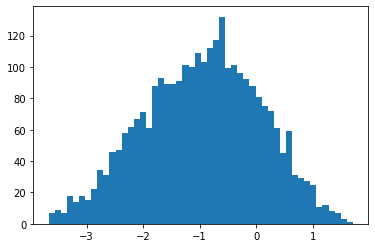

In [8]:
hist1 = plt.hist(data['target'], bins=50)
plt.show()

In [9]:
nlp = spacy.load("en_core_web_lg")

In [10]:
with nlp.disable_pipes():
    data_vecs = np.array([nlp(text).vector for text in data['excerpt']])
    data_lbls = data['target']

In [24]:
nlp('hello my name is')

4

In [27]:
nlp_texts = [nlp(text) for text in data['excerpt']]

In [33]:
data = torch.zeros((len(nlp_texts), 300, 300))

for i in range(len(nlp_texts)):
    text = nlp_texts[i]
    zeroes[i][0:min(len(text), 300)] = torch.tensor([word.vector for word in text[0:min(len(text), 300)]])

In [35]:
zeroes.shape

torch.Size([2834, 300, 300])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data_vecs, data_lbls, test_size=0.1)

In [94]:
np.sqrt(mean_squared_error(np.full((data.shape[0],),data['target'].mean()), data['target']))

1.033396832247627

In [100]:
params = {
    'base_score': 0.5,
    'n_estimators': 200,
    'max_depth': 2,
    'learning_rate': 0.1,
    'verbosity': 1,2
    'random_state': random_state
}
model = xgb.XGBRegressor(objective="reg:squarederror", **params)

In [101]:
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [102]:
y_pred = model.predict(X_test)

In [104]:
np.sqrt(mean_squared_error(y_pred, y_test))

0.6603736247497498